In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
%config InlineBackend.figure_format = 'svg'

In [2]:
Types = ["Alignedv2", "Shiftedv2","Diskv2", "Rot30v2"]
Paths = ["Aligned", "Shifted","Disk", "Rotated"]

data = []
meta = []
tot_tracks = []

# Load the data into a dataframe
for index, t in enumerate(Types):
    print("Loading type: ", t)
    data.append(pd.read_csv(f"../Files/{Paths[index]}/EventInfo_merge_{t}.csv", delimiter = ",", names = ["event", "x", "y", "z", "t"]))
    
    # Cut the first time bin
    data[index] = data[index][data[index]['t'] > 200]

    # Here we subtract off the first time bin to shift all the EL values to zero
    data_copy = data[index].copy(deep=True)

    data_sub = data_copy.drop_duplicates(subset= ["event"], keep='first')
    data_sub = data_sub.drop(columns = ["x", "y", "z"])

    data_copy['Count'] = 1
    data_copy = data_copy.groupby(["event"]).Count.count().reset_index()

    # get a dataframe with the first time row to subtract from
    data_merge = pd.DataFrame()
    data_sub = data_sub.merge(data_copy, on='event', how="inner")
    data_sub = data_sub.reset_index(drop = True)
    data_sub = data_sub.loc[data_sub.index.repeat(data_sub.Count)]
    data_sub = data_sub.drop(columns = ["Count"])
    data_sub = data_sub.rename(columns={"t": "t_sub"})
    data_sub = data_sub.reset_index(drop=True)


    data[index] = data[index].reset_index(drop=True)
    data[index]["t"] = data[index]["t"] - data_sub["t_sub"]
    
    # Apply a radial cut
    # rad_cut = data[index][ np.sqrt(data[index]['x']*data[index]['x'] + data[index]['y']*data[index]['y']) >= 0.15]['event'].unique()
    # data[index] = data[index][~data[index].event.isin(rad_cut)]

    tot_tracks.append(len(data[index]['event'].unique()))

    # Load the data into a dataframe
    # if (t == "Rot30"):
    #     meta.append(pd.read_csv(f"../Files/{Paths[index]}/Metadata_merge_{t}.csv", delimiter = ",", names = ["event","electrons","ions","elastic","ionisations","attachment","inelastic","excitation","top","bottom","start x","start y","start z"]))
    # else:
    meta.append(pd.read_csv(f"../Files/{Paths[index]}/Metadata_merge_{t}.csv", delimiter = ",", names = ["event","electrons","ions","elastic","ionisations","attachment","inelastic","excitation","top","bottom","start x","start y","start z", "start E", "end E"]))




Loading type:  Alignedv2
Loading type:  Shiftedv2
Loading type:  Diskv2
Loading type:  Rot30v2


In [3]:
# Print some additional info
for index, t in enumerate(Types):
    print(t)
    print("Mean VuV: ", meta[index]['excitation'].mean())
    print("STD/Mean VuV: ", 100*meta[index]['excitation'].std()/meta[index]['excitation'].mean())
    print("Total tracks: ", tot_tracks[index])
    print("\n")

Alignedv2
Mean VuV:  1031.9519288577155
STD/Mean VuV:  3.4200904359025297
Total tracks:  39920


Shiftedv2
Mean VuV:  1151.5704728370222
STD/Mean VuV:  1.9796707449706428
Total tracks:  39760


Diskv2
Mean VuV:  1162.2106
STD/Mean VuV:  1.2516826403751826
Total tracks:  40000


Rot30v2
Mean VuV:  1114.9091933867735
STD/Mean VuV:  4.721452000536355
Total tracks:  79840




In [4]:
# Bin the scatters in time
tmin=0
tmax=10000
tbw=50


tbins = np.arange(tmin, tmax+tbw, tbw)
tbins_centre = np.arange(tmin+tbw/2, tmax+tbw/2, tbw)

avg = []
std = []

for index, t in enumerate(Types):
    data[index]['t'] = pd.cut(x=data[index]['t'], bins=tbins,labels=tbins_centre, include_lowest=True) # bin the time 

    # Now average over the events
    avg.append(data[index].groupby(['t']).count())
    avg[index] = avg[index].fillna(0)
    avg[index].reset_index(inplace=True) 

    std.append(data[index].groupby(['t']).std())
    std[index] = std[index].fillna(0)
    std[index].reset_index(inplace=True) 


display(avg[0])


,t,event,x,y,z
0,25.0,98351,98351,98351,98351
1,75.0,108144,108144,108144,108144
2,125.0,178928,178928,178928,178928
3,175.0,262092,262092,262092,262092
4,225.0,345837,345837,345837,345837
...,...,...,...,...,...
195,9775.0,0,0,0,0
196,9825.0,0,0,0,0
197,9875.0,0,0,0,0
198,9925.0,0,0,0,0


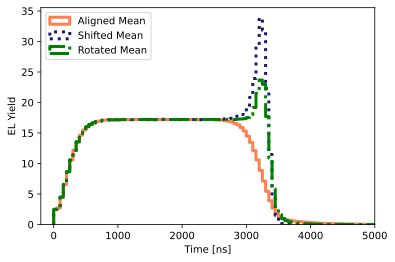

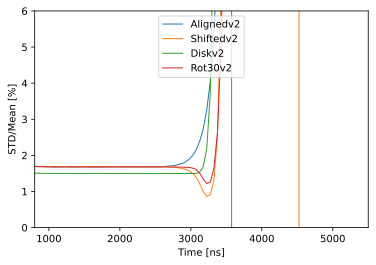

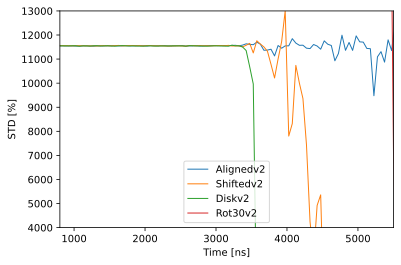

In [5]:
# Make a plot of the timing profile of the EL emission
from matplotlib.lines import lineStyles

vlines = ["solid", "dotted", "dashed", "dashdot"]
PlotTypes = ["Aligned", "Shifted","Disk", "Rotated"]
colTypes = ["coral", "midnightblue","green", "green"]

hist_data = []

plt.figure()
for index, t in enumerate(Types):
    if (index == 2): continue
    counts, bins, _ = plt.hist(avg[index]['t'], weights = avg[index]['event']/tot_tracks[index],bins = np.arange(tmin, tmax+tbw, tbw), histtype="step", linewidth=3,linestyle=vlines[index], label=f"{PlotTypes[index]} Mean", color = colTypes[index])
    hist_data.append(counts)
    # print(np.array(hist_data[index])[57:58].sum())




plt.xlim(-200, 5000)
# plt.xlim(3000, 8000 )

plt.xlabel("Time [ns]")
plt.ylabel("EL Yield")
plt.legend(loc = "upper left")
plt.savefig("../Plots/Combined/Yield_vs_Time.pdf")

plt.figure()
for index, t in enumerate(Types):
    plt.plot(avg[index]['t'], 100*std[index]['event']/avg[index]['event'], linewidth=1, label=Types[index])
plt.xlabel("Time [ns]")
plt.ylabel("STD/Mean [%]")
plt.xlim(-200, 6200)
plt.ylim(0, 6 )
plt.xlim(800, 5500 )
plt.legend(loc = "upper center")
plt.savefig("../Plots/Combined/Fluctuations_vs_Time.pdf")

plt.figure()
for index, t in enumerate(Types):
    plt.plot(avg[index]['t'], std[index]['event'], linewidth=1, label=Types[index])
plt.xlabel("Time [ns]")
plt.ylabel("STD [%]")
plt.xlim(-200, 6200)
plt.xlim(800, 5500 )
plt.ylim(4000, 13000 )
plt.legend(loc = "lower center")
plt.savefig("../Plots/Combined/Fluctuations_vs_Time.pdf")


1032.5053308537845
1031.9019288577153

1151.7460922512812
1151.5204728370222

1116.1011976369946
1114.8591933867735



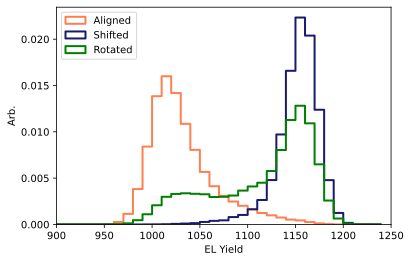

In [6]:
data_align_tot = []

plt.figure()

# Plot the total EL yield for each configuration
for index, t in enumerate(Types):
   
    data_align_tot.append(data[index].pivot_table(columns=['event'], aggfunc='size').reset_index())
    data_align_tot[index].columns = ['event', 'Yield']
    
    if (index == 2):
        continue
    plt.hist(data_align_tot[index]['Yield'], bins = np.arange(900, 1250, 10), histtype="step", linewidth=2, label=PlotTypes[index], density =True, color = colTypes[index] )

    # Also calculate the RMS
    RMS = np.sqrt(sum(data_align_tot[index]['Yield']*data_align_tot[index]['Yield'])/len(data_align_tot[index]['Yield']))
    print(RMS)
    print(np.mean(data_align_tot[index]['Yield']))
    print("")

plt.xlim(900, 1250)
plt.xlabel("EL Yield")
plt.ylabel("Arb.")
plt.legend(loc = 'upper left')
plt.savefig("../Plots/Combined/YieldTotal.pdf")


0        1.604425
1        1.931269
2        5.097305
3        8.085884
4        1.912164
           ...   
39915    2.417280
39916    8.168886
39917    6.913299
39918    5.044169
39919    5.602591
Name: end E, Length: 39920, dtype: float64

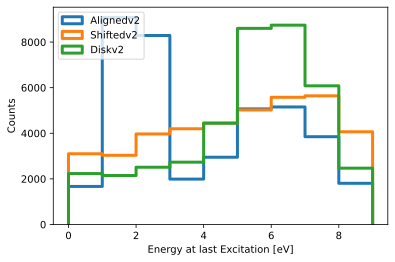

In [7]:
# Plot the energies of the events
plt.figure()

display(meta[0]['end E'])

# Plot the total EL yield for each configuration
for index, t in enumerate(Types):
    if (index == 3): continue;
    plt.hist(meta[index]['end E'], bins = np.arange(0, 10, 1), histtype="step", linewidth=3, label=Types[index] )

plt.xlabel("Energy at last Excitation [eV]")
plt.ylabel("Counts")
plt.legend(loc = 'upper left')
plt.savefig("../Plots/Combined/EndEnergy.pdf")